# **Deep Convolutional GAN** 

In this project we will use the CIFAR10 dataset and another open sourced dataset from kaggle,

for creating new images using DCGAN.


## **GAN on celebA dataset**

### Libraries and Uploading data

In [1]:
import numpy as np
import PIL
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import random
import time
import sys
from IPython import display

In [2]:
# To generate GIFs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mbwe0cxo
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-mbwe0cxo
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184155 sha256=cd1cd26859c06ca3fbd2f91d58ec1a9c24f7400d9846bdef98133625dbd32bda
  Stored in directory: /tmp/pip-ephem-wheel-cache-unq_auth/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
! pip install -U -q kaggle
! mkdir -p ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/
! kaggle datasets download jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:08<00:00, 191MB/s]
100% 1.33G/1.33G [00:08<00:00, 168MB/s]


In [8]:
import zipfile

with zipfile.ZipFile('celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('CelebA')

In [9]:
MAIN_PATH = 'CelebA/img_align_celeba/img_align_celeba'

image_paths = glob((MAIN_PATH + "/*.jpg"))

In [10]:
print(f'There are {len(image_paths)} images in the dataset')

There are 202599 images in the dataset


In [11]:
image_paths = image_paths[0:40000]

### Preprocessing data

In [12]:
def readImage(path,image_size=(256,256)):
    img = np.asarray(PIL.Image.open(path).resize(image_size))
    # img - 127.5 / 127.5 ==> compress between [-1,1]
    img = ((img - 127.5) / 127.5).astype("float32")
    #img = img.astype('float32') / 127.5 -1
    return img

(256, 256, 3)


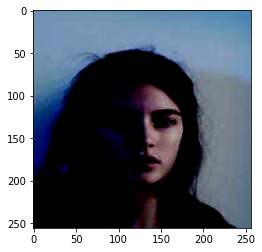

In [13]:
test_img = readImage(image_paths[0])
print(test_img.shape)

plt.imshow(test_img)
plt.show()

In [14]:
BATCH_SIZE = 128
STEPS_PER_EPOCH = len(image_paths) // BATCH_SIZE # steps per epoch
def dataGenerator(batch_size):
    while True:
        paths = random.choices(image_paths,k=batch_size)
        batch = []
        for p in paths:
            batch.append(readImage(p))
        
        yield np.asarray(batch)

dataGen = dataGenerator(BATCH_SIZE)
print(next(dataGen).shape)

(128, 256, 256, 3)


In [15]:
def define_generator():
    model = tf.keras.Sequential()
    
    # Random noise to 16x16x256 image
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,16,256)))
    
    assert model.output_shape == (None,16,16,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,32,32,128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,64,64,64)
    
    model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),use_bias=False,padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    assert model.output_shape == (None,128,128,32)

    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding='same',activation='tanh'))
              # Tanh activation function compress values between -1 and 1. 
              # This is why we compressed our images between -1 and 1 in readImage function.
    assert model.output_shape == (None,256,256,3)
    return model


In [16]:
generator = define_generator()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      5

In [17]:
# we'll use cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # First argument of loss is real labels
    # We've labeled our images as 1 (real) because
    # we're trying to fool discriminator
    return cross_entropy(tf.ones_like(fake_output),fake_output)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [18]:
def make_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64,(3,3),strides=(2,2),padding="same",input_shape=(256,256,3)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64,(3,3),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [19]:
discriminator = make_discriminator()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                      

In [20]:
def discriminator_loss(real_images,fake_images):
    real_loss = cross_entropy(tf.ones_like(real_images),real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [21]:
EPOCHS = 30
NOISE_DIM = 100
num_examples_to_generate = 16

@tf.function
def train_step(images):
    # We've created random seeds
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator generated images
        generated_images = generator(noise,training=True)
        
        # We've sent our real and fake images to the discriminator
        # and taken the decisions of it.
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        # We've computed losses of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    # We've computed gradients of networks and updated variables using those gradients.
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [22]:
def train(epochs):
    for epoch in range(1, epochs+1):
        start = time.time()
        for step in range(STEPS_PER_EPOCH):
            train_step(next(dataGen))
    
            sys.stdout.write(f"\rSTEP: {step}/{STEPS_PER_EPOCH}")
            sys.stdout.flush()

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
            
        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # for generating the fake images after each epoch
  predictions = np.asarray(model(test_input, training=False))

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(((predictions[i, :, :, :] * 127.5) + 127.5).astype("int"))
    
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
tf.keras.backend.clear_session()

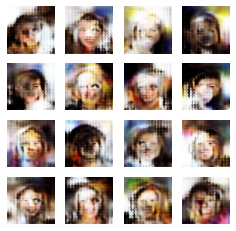

In [25]:
# for visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

train(EPOCHS)

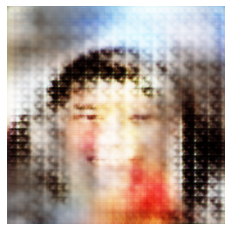

In [32]:
test = tf.random.normal([1, NOISE_DIM])

predictions = np.asarray(generator(test, training=False))

plt.imshow((predictions[0] * 127.5 + 127.5).astype("int"))
plt.axis('off')

plt.savefig('Test.png')
plt.show()